# PCA와 t-SNE를 이용한 Mnist 데이터 시각화

In [37]:
import time

import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns


## 데이터 불러오기

In [38]:
mnist = fetch_openml('mnist_784',version=1,cache=True)
mnist.target = mnist.target.astype(np.int8)

#### fetch_mldata는 scikit-learn 0.20 이후부터는 지원하지 않음<br><br>fetch_openml() 사용 [target을 기준으로 정렬하지 않으므로 sort 함수 정의]####

In [39]:
def sort_by_target(mnist): 
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1] 
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1] 
    mnist.data[:60000] = mnist.data[reorder_train] 
    mnist.target[:60000] = mnist.target[reorder_train] 
    mnist.data[60000:] = mnist.data[reorder_test + 60000] 
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

sort_by_target(mnist)

In [40]:
X = mnist.data/255.0
y = mnist.target
print(X.shape,y.shape)

(70000, 784) (70000,)


In [41]:
feat_cols = ['pixel'+str(i) for i in range(X.shape[1])]
df = pd.DataFrame(X,columns=feat_cols)
df['y'] = y
df['label'] = df['y'].apply(lambda i:str(i))

X,y = None,None
print('데이터 사이즈 : {}'.format(df.shape))

데이터 사이즈 : (70000, 786)


### 데이터 random 추출

In [42]:
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])

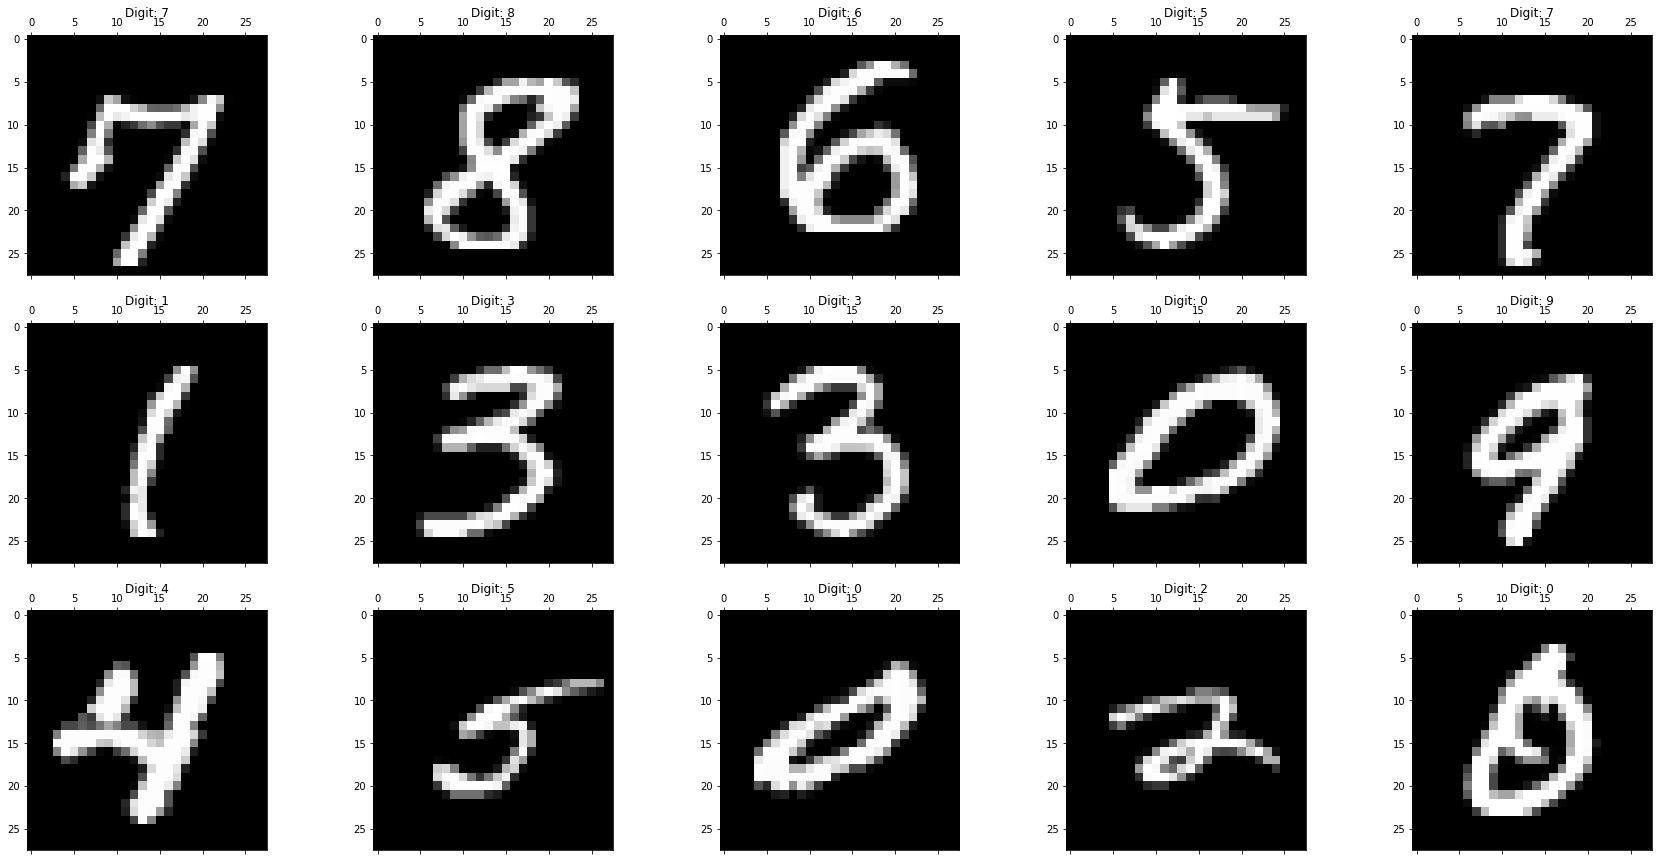

In [43]:
fig = plt.figure(figsize=(30,15))
plt.gray()
for i in range(0,15):
    ax = fig.add_subplot(3,5,i+1, title="Digit: {}".format(str(df.loc[rndperm[i],'label'])) )
    ax.matshow(df.loc[rndperm[i],feat_cols].values.reshape((28,28)).astype(float))

## PCA

In [44]:
pca = PCA(n_components = 3) #PC 3개만 사용
pca_result = pca.fit_transform(df[feat_cols].values) #fit과 transform 함께 수행하는 메소드
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1]
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_)) #각각의 주성분 벡터가 이루는 축에 projection한 결과의 분산 비율

Explained variation per principal component: [0.09746116 0.07155445 0.06149531]


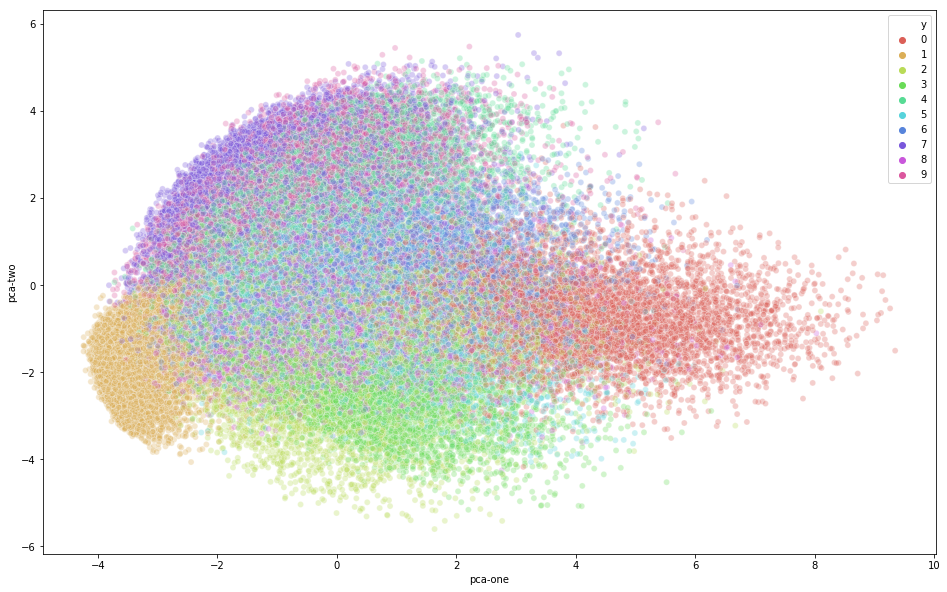

In [45]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x = 'pca-one',
    y = 'pca-two',
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df.loc[rndperm,:],
    legend="full",
    alpha=0.3    
)

## t-SNE

In [46]:
N = 10000
df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.09730166 0.07135901 0.06183721]


In [47]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 2.919s...
[t-SNE] Computed neighbors for 10000 samples in 149.406s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.129022
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.064781
[t-SNE] KL divergence after 300 iterations: 2.819744
t-SNE done! Time elapse

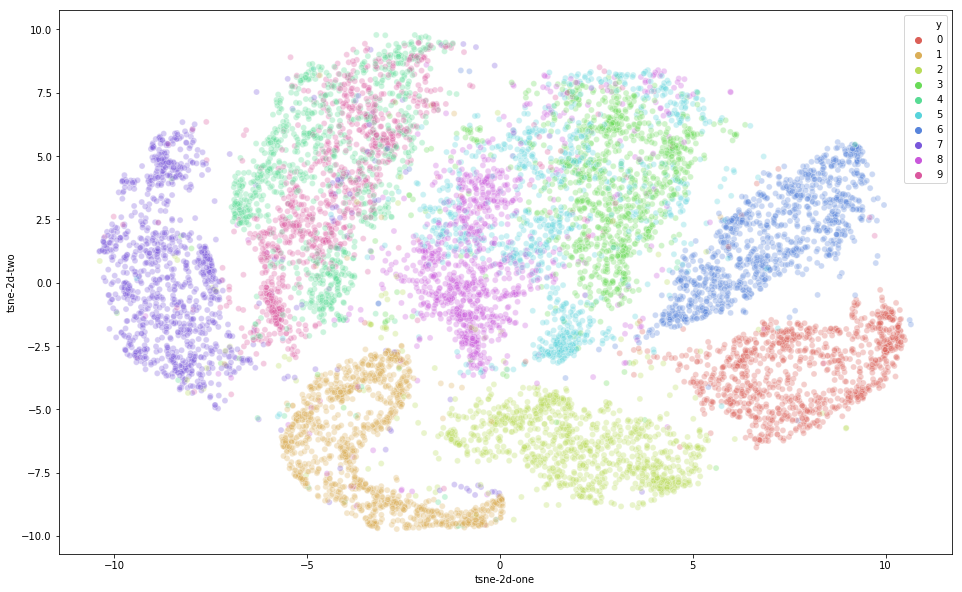

In [48]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)

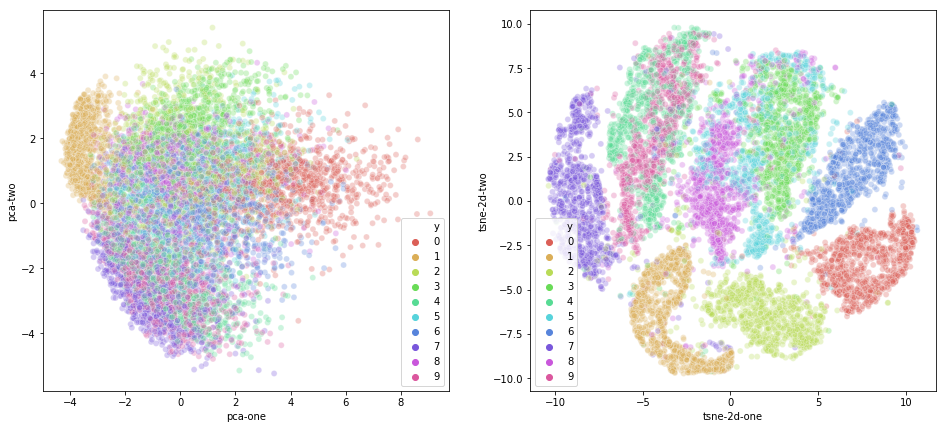

In [49]:
plt.figure(figsize=(16,7))
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax2
)

In [50]:
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(data_subset)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

Cumulative explained variation for 50 principal components: 0.8267553211494856


In [51]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result_50)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 41.35603880882263 seconds


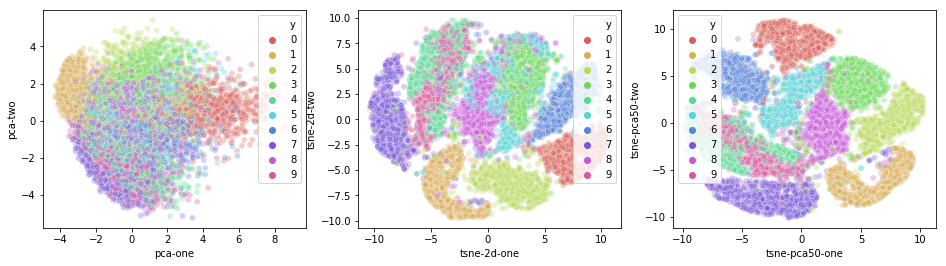

In [52]:
df_subset['tsne-pca50-one'] = tsne_pca_results[:,0]
df_subset['tsne-pca50-two'] = tsne_pca_results[:,1]
plt.figure(figsize=(16,4))
ax1 = plt.subplot(1, 3, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax2 = plt.subplot(1, 3, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax2
)
ax3 = plt.subplot(1, 3, 3)
sns.scatterplot(
    x="tsne-pca50-one", y="tsne-pca50-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax3
)